# Project 1

### Ваша задача на основе постеров фильмов предсказывать его жанры:

- Сбор датасета постеров фильмов и их жанров:
1. Тут можно найти датасет постеров фильмов: https://www.kaggle.com/datasets/phiitm/movie-posters
2. Здесь датасет с мета информацией о фильме: https://www.kaggle.com/code/phiitm/can-we-judge-a-movie-by-it-s-poster/notebook

- Анализ датасета
1. Распределение классов
2. Анализ того, какие жанры чаще всего встречаются у одного фильма (чаще всего у фильма не один жанр)
3. Визуализировать состав датасета

- Предобработка изображений
1. Анализ качества изображений
2. Добавить аугментации

- Модели, которые нужно протестировать:
1. Своя архитектура CNN
2. Resnet
3. Классификатор на основе эмбеддингов ViT (сам ViT учить не надо, только голову)

- Анализ результатов
1. Метрики качества, графики
2. Визуализация примеров, где модель ошибается
3. Выводы


In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from albumentations import Compose, RandomCrop, HorizontalFlip, RandomBrightnessContrast
from albumentations.pytorch import ToTensorV2

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

from torchvision.models import resnet50

from transformers import ViTFeatureExtractor, ViTForImageClassification

## DataSet Analysis

In [107]:
metadata_path = "../data/MovieGenre.csv"
posters_path = "../data/SampleMoviePosters/"


metadata = pd.read_csv(metadata_path, encoding="utf-8", encoding_errors="replace", engine="python")

In [66]:
print(metadata.columns)
metadata.head(2)

Index(['imdbId', 'Imdb Link', 'Title', 'IMDB Score', 'Genre', 'Poster'], dtype='object')


,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...


In [67]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40108 entries, 0 to 40107
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   imdbId      40108 non-null  int64  
 1   Imdb Link   40108 non-null  object 
 2   Title       40108 non-null  object 
 3   IMDB Score  40060 non-null  float64
 4   Genre       39963 non-null  object 
 5   Poster      39383 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.8+ MB


In [69]:
metadata = metadata.dropna(subset=['Genre', 'Poster'])

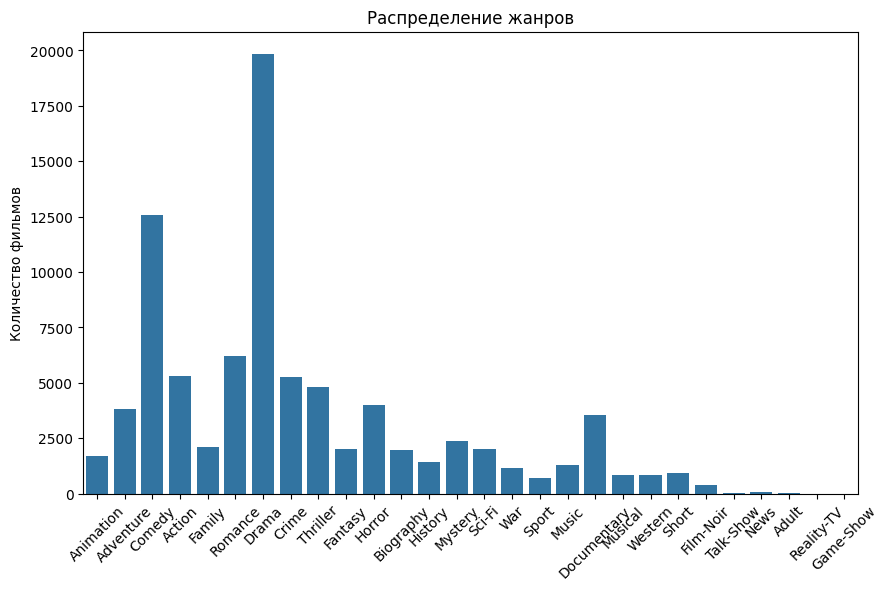

In [70]:
genres = metadata['Genre'].apply(lambda x: x.split('|'))
genre_counts = Counter([genre for sublist in genres for genre in sublist])

plt.figure(figsize=(10, 6))
sns.barplot(x=list(genre_counts.keys()), y=list(genre_counts.values()))
plt.title("Распределение жанров")
plt.xticks(rotation=45)
plt.ylabel("Количество фильмов")
plt.show()

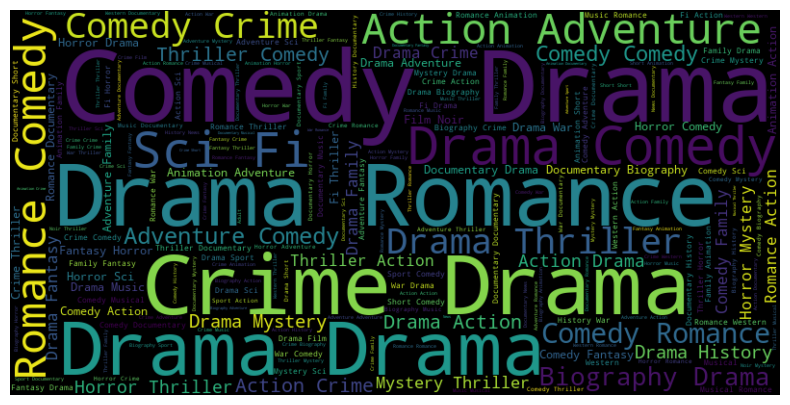

In [80]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400).generate(' '.join(metadata['Genre']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Image Preprocessing

In [ ]:
def check_image_quality(image_path):
    try:
        img = Image.open(image_path)
        return img.size[0] > 100 and img.size[1] > 100
    except:
        return False

valid_images = [img for img in os.listdir(posters_path) if check_image_quality(os.path.join(posters_path, img))]

In [83]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

In [ ]:
import os
import json
import glob
import numpy as np
import pandas as pd
from urllib.request import urlretrieve
from sklearn.model_selection import train_test_split
import imageio.v3 as iio
import cv2
from skimage.transform import resize

def process_labels(genres):
    label_dict = {"genre2id": {}, "id2genre": []}
    idx = 0
    for g_row in genres:
        for g in g_row:
            if g not in label_dict["id2genre"]:
                label_dict["id2genre"].append(g)
                label_dict["genre2id"][g] = idx
                idx += 1
    print(f"Identified {len(label_dict['id2genre'])} classes.")
    return label_dict

def download_posters(df, savelocation):
    if not os.path.exists(savelocation):
        os.makedirs(savelocation)
    poster_not_found = []
    for idx, row in df.iterrows():
        url = row['Poster']
        if "https://images-na.ssl-images-amazon.com/images/" in str(url):
            imagename = os.path.join(savelocation, f"{row['imdbId']}.jpg")
            try:
                urlretrieve(url, imagename)
            except:
                poster_not_found.append(idx)
    df.drop(poster_not_found, inplace=True)

def preprocess_image(img, size):
    img_resized = resize(img, size, anti_aliasing=True)
    return img_resized.astype(np.float32)

def prepare_data(data, posters_dict, label_dict, size):
    x, y, ids = [], [], []
    n_classes = len(label_dict["id2genre"])
    for idx in posters_dict:
        try:
            img = preprocess_image(posters_dict[idx], size)
            genres = data.loc[data['imdbId'] == int(idx), 'Genre'].values[0].split('|')
            label = np.sum([np.eye(n_classes)[label_dict["genre2id"][g]] for g in genres], axis=0)
            x.append(img)
            y.append(label)
            ids.append(idx)
        except Exception as e:
            print(f"Error processing {idx}: {e}")
            continue
    return np.array(x), np.array(y)

csv_path = "../data/MovieGenre.csv"
poster_path = "../data/SampleMoviePosters/"
df = pd.read_csv(csv_path, encoding="utf-8", encoding_errors="replace", engine="python")

genres = df['Genre'].apply(lambda row: str(row).split("|"))
label_dict = process_labels(genres)

with open('label.json', 'w') as lf:
    json.dump(label_dict, lf)

image_glob = glob.glob(os.path.join(poster_path, "*.jpg"))
posters_dict = {os.path.basename(img).split(".")[0]: iio.imread(img) for img in image_glob}

img_size = (150, 100, 3)
x, y = prepare_data(df, posters_dict, label_dict, img_size)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

np.savez("movie_genre_data.npz", x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

Identified 29 classes.
x_train shape: (897, 150, 100, 3)
y_train shape: (897, 29)
x_test shape: (100, 150, 100, 3)
y_test shape: (100, 29)


## Model Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

num_of_filters = 32
num_of_labels = len(label_dict["id2genre"])  
batch_size = 16
epochs = 4
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Number of Labels: {num_of_labels}")
print(f"Training Data Shape: {x_train.shape}")

x_train = x_train.permute(0, 3, 1, 2)
x_test = x_test.permute(0, 3, 1, 2)

x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(64 * (150 // 4) * (100 // 4), 128) 
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.pool(x)

        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        return self.sigmoid(self.fc2(x))  


model = CNN(num_classes=num_of_labels).to(device)

criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()  
        total += labels.size(0) * labels.size(1)  
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

torch.save(model.state_dict(), "gpre.pth")
print("Model saved to gpre.pth")

Number of Labels: 29
Training Data Shape: torch.Size([897, 150, 100, 3])


C:\Users\User\AppData\Local\Temp\ipykernel_12572\3139271265.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
C:\Users\User\AppData\Local\Temp\ipykernel_12572\3139271265.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
C:\Users\User\AppData\Local\Temp\ipykernel_12572\3139271265.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
C:\Users\User\A

Epoch [1/4], Loss: 0.2294
Epoch [2/4], Loss: 0.1969
Epoch [3/4], Loss: 0.1943
Epoch [4/4], Loss: 0.1856
Validation Accuracy: 92.86%
Model saved to gpre.pth


In [ ]:
genres = metadata.Genre.unique()
genre_dict = {idx: str(genre) for idx, genre in enumerate(genres) if isinstance(genre, str)}
all_genres = []
for genre_string in genre_dict.values():
    all_genres.extend(genre_string.split('|'))

unique_genres = sorted(set(all_genres)) 
# print("Unique Genres:", unique_genres)

genre_mapping = {genre: idx for idx, genre in enumerate(unique_genres)}
print("Genre Mapping:", genre_mapping)

movie_genre_indices = {
    movie_id: [genre_mapping[genre] for genre in genres.split('|') if genre in genre_mapping]
    for movie_id, genres in genre_dict.items()
}
# print("Movie Genre Indices:", movie_genre_indices)

Genre Mapping: {'Action': 0, 'Adult': 1, 'Adventure': 2, 'Animation': 3, 'Biography': 4, 'Comedy': 5, 'Crime': 6, 'Documentary': 7, 'Drama': 8, 'Family': 9, 'Fantasy': 10, 'Film-Noir': 11, 'Game-Show': 12, 'History': 13, 'Horror': 14, 'Music': 15, 'Musical': 16, 'Mystery': 17, 'News': 18, 'Reality-TV': 19, 'Romance': 20, 'Sci-Fi': 21, 'Short': 22, 'Sport': 23, 'Talk-Show': 24, 'Thriller': 25, 'War': 26, 'Western': 27}


In [ ]:
# import torch
# import torch.nn as nn
# from torchvision import transforms
# from PIL import Image

# # Model definition
# class CNN(nn.Module):
#     def __init__(self, num_classes):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) # Input channels = 3
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Changed stride to 2 for downsampling
        
#         self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
#         self.flatten = nn.Flatten()
        
#         self.fc1 = nn.Linear(64 * (150 // 4) * (100 // 4), 128)  # Adjusted for input shape after pooling
#         self.dropout1 = nn.Dropout(0.25)
#         self.dropout2 = nn.Dropout(0.2)
#         self.fc2 = nn.Linear(128, num_classes)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = torch.relu(self.conv1(x))
#         x = torch.relu(self.conv2(x))
#         x = self.pool(x)
        
#         x = torch.relu(self.conv3(x))
#         x = torch.relu(self.conv4(x))
#         x = self.pool(x)

#         x = self.flatten(x)
#         x = torch.relu(self.fc1(x))
#         x = self.dropout1(x)
#         return self.sigmoid(self.fc2(x))

# model = CNN(num_classes=num_of_labels).to(device)
# model.load_state_dict(torch.load("gpre.pth"))
# model.eval()

# transform = transforms.Compose([
#     transforms.Resize((150, 100)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

# image_path = "../test-images/ff6.jpg"
# image = Image.open(image_path).convert('RGB')
# input_tensor = transform(image).unsqueeze(0)

# output = model(input_tensor)
# _, predicted_idx = torch.max(output, dim=1)
# predicted_idx_value = predicted_idx.item()

# predicted_genre = list(genre_mapping.keys())[list(genre_mapping.values()).index(predicted_idx_value)]

# print(f"Predicted Genre: {predicted_genre}")

### Testing CNN

In [ ]:
import torch
import json
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(64 * (150 // 4) * (100 // 4), 128) 
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.pool(x)

        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        return self.sigmoid(self.fc2(x)) 

model = CNN(num_classes=num_of_labels).to(device)
model.load_state_dict(torch.load("gpre.pth"))
model.eval()

def preprocess_img(image_path, size=(150, 100)):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = transform(image).unsqueeze(0)  
    return image

with open("label.json", "r") as f:
    labels = json.load(f)

image_name = "ff6.jpg"  
image_path = f"../test-images/{image_name}"

input_tensor = preprocess_img(image_path)

output = model(input_tensor)
output = output.squeeze().detach().numpy()  

ids = output.argsort()[::-1][:5]

for idx in ids:
    print(labels['id2genre'][idx], round(output[idx], 2), '%')

image = cv2.imread(image_path)
cv2.imshow("Movie: ", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

C:\Users\User\AppData\Local\Temp\ipykernel_12572\3747023068.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("gpre.pth"))


Drama 0.57 %
Comedy 0.4 %
Romance 0.34 %
Short 0.12 %
Adventure 0.11 %


### ResNet

In [166]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models

# Parameters
num_of_labels = len(label_dict["id2genre"])  
batch_size = 16
epochs = 4
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reshape inputs for ResNet
# Ensure input has correct shape for ResNet
x_train = x_train.permute(0, 3, 1, 2)  # Ensure [samples, channels, height, width]
if x_train.shape[1] != 3:  # If channels != 3, fix it
    x_train = x_train.mean(dim=1, keepdim=True).repeat(1, 3, 1, 1)  # Example fix to make 3 channels

x_test = x_test.permute(0, 3, 1, 2)
if x_test.shape[1] != 3:
    x_test = x_test.mean(dim=1, keepdim=True).repeat(1, 3, 1, 1)


x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ResNet Model
class ResNetMultiLabel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetMultiLabel, self).__init__()
        self.base_model = models.resnet50(pretrained=True)  # Load pre-trained ResNet50
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, num_classes),
            nn.Sigmoid()  # Multi-label classification
        )

    def forward(self, x):
        return self.base_model(x)

model = ResNetMultiLabel(num_classes=num_of_labels).to(device)

# Loss and Optimizer
criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Validation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        total += labels.size(0) * labels.size(1)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

torch.save(model.state_dict(), "resnet_model.pth")
print("Model saved to resnet_model.pth")

C:\Users\User\AppData\Local\Temp\ipykernel_12572\2056148241.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
C:\Users\User\AppData\Local\Temp\ipykernel_12572\2056148241.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
C:\Users\User\AppData\Local\Temp\ipykernel_12572\2056148241.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
C:\Users\User\A

Epoch [1/4], Loss: 0.2274
Epoch [2/4], Loss: 0.2077
Epoch [3/4], Loss: 0.1892
Epoch [4/4], Loss: 0.1903
Validation Accuracy: 92.62%
Model saved to resnet_model.pth


In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Parameters
num_of_labels = len(label_dict["id2genre"])  
batch_size = 16
epochs = 4
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Processor for Vision Transformer
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")


# Preprocess Dataset
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

def preprocess_images(images, processor):
    """
    Resizes and normalizes images using the ViTImageProcessor.
    Args:
        images (torch.Tensor): Input images tensor of shape (N, C, H, W).
        processor (ViTImageProcessor): Processor for resizing and normalization.

    Returns:
        torch.Tensor: Preprocessed images tensor.
    """
    images = images.permute(0, 2, 3, 1).cpu().numpy()  # Convert to (N, H, W, C) for processor
    processed_images = processor(images=list(images), return_tensors="pt")["pixel_values"]
    return processed_images.to(device)

x_train = preprocess_images(x_train, processor)
x_test = preprocess_images(x_test, processor)

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ViT Model
class ViTMultiLabel(nn.Module):
    def __init__(self, num_classes):
        super(ViTMultiLabel, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k")
        self.vit.classifier = nn.Sequential(
            nn.Linear(self.vit.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.vit(x).logits

model = ViTMultiLabel(num_classes=num_of_labels).to(device)

# Loss and Optimizer
criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Validation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        total += labels.size(0) * labels.size(1)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

torch.save(model.state_dict(), "vit_model.pth")
print("Model saved to vit_model.pth")

C:\Users\User\AppData\Local\Temp\ipykernel_12572\3533623395.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
C:\Users\User\AppData\Local\Temp\ipykernel_12572\3533623395.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
C:\Users\User\AppData\Local\Temp\ipykernel_12572\3533623395.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
C:\Users\User\A